In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('..')

print(f'cwd: {os.getcwd()}')

cwd: /Users/gbemidebe/Documents/GitHub/RLseparation


In [3]:
# images folder
images_path = 'images/rl/reward-one'
numerical_id = 1
if not os.path.exists(images_path):
    os.makedirs(images_path)
else:
    os.system(f'rm {images_path}/*')
    
# model path
model_path = 'models/reward-one'
if not os.path.exists(model_path):
    os.makedirs(model_path)
else:
    os.system(f'rm {model_path}/*')

## Import libraries

In [4]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3 import A2C, PPO, SAC

from OptiDial import (RLperformanceMetrics, ENV,
                     simulate, rolling_average, rescale_action, 
                     rescale_eposide_rewards, reward_one)

In [5]:
RLperformanceMetrics?

Init signature:
RLperformanceMetrics(
    print_info=False,
    params_files='params.yaml',
    timesteps=20,
    method='solve_ivp',
    lb: list = [15, 0.1, 45, 0.1, 0.01],
    ub: list = [80, 2.0, 120, 2.0, 0.5],
)
Docstring:     
Custom environment metrics for the electrodialysis simulation
Parameters:
----------
    print_info: bool, print the information
    params_files: str, parameters file
    steps: int, number of steps
    method: str, method to solve the physics model
File:           ~/Documents/GitHub/RLseparation/OptiDial/rl/utils.py
Type:           type
Subclasses:     

In [6]:
rlmetrics = RLperformanceMetrics(params_files='OptiDial/params.yaml')
rlmetrics

In [7]:
rlmetrics.operate?

Signature: rlmetrics.operate(action: <built-in function array>, rescale: bool = True)
Docstring:
Execute the physics model
Parameters:
----------
    action: np.array, [N, Estack, T_tot, Feed, VT_dil, VT_conc]
    rescale: bool, rescale the action space
    lb: list, lower bound of the action space
    ub: list, upper bound of the action space
Returns:
-------
    metrics: tuple
    SR: float, separation efficiency
    EC: float, energy consumption
    Cdil_f: float, final concentration in diluate stream
    Cconc_f: float, final concentration in concentrate stream
File:      ~/Documents/GitHub/RLseparation/OptiDial/rl/utils.py
Type:      method

In [8]:
N = 80
Estack = 1
T_tot = 100
VT_dil = 0.3
VT_conc = 0.1

# SR, EC, Cdil_f, Cconc_f
rlmetrics.operate(action=[N, Estack, T_tot, VT_dil, VT_conc], rescale=False) #, Feed, VT_dil, VT_conc])

(0.97377968013229,
 1.0479737465022958,
 0.8971880194254929,
 129.67562181095548,
 False)

## Environment

In [9]:
# performance metrics
lb = [20, 0.1, 45, 0.1, 0.01] # lower bound for the action space
ub = [80, 2.0, 120, 2.0, 0.5] # upper bound for the action space
metrics = RLperformanceMetrics(params_files='OptiDial/params.yaml',
                               lb=lb, ub=ub)
# custom environment
env = ENV(rl_metrics=metrics, max_steps=1, reward_function=reward_one, reward_weight=None)
# check the env (If the environment don't follow the interface, an error will be thrown)
check_env(env, warn=True)

# Train controller

In [10]:
number_of_episodes = 30_000 # number of episodes
max_steps = 1 # number of steps per episode
window_size = 100 # window size for the rolling average
lb = [15, 0.1, 45, 0.1, 0.01] # lower bound for the action space
ub = [80, 2.0, 120, 2.0, 0.5] # upper bound for the action space

### A. PPO

In [11]:
# Choose your algorithm
ppo_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_one))
ppo_model = PPO("MlpPolicy", ppo_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
ppo_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.555    |
| time/              |          |
|    fps             | 91       |
|    iterations      | 1        |
|    time_elapsed    | 22       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1          |
|    ep_rew_mean          | 0.649      |
| time/                   |            |
|    fps                  | 88         |
|    iterations           | 2          |
|    time_elapsed         | 46         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.14885017 |
|    clip_fraction        | 0.614      |
|    clip_range           | 0.2        |
|    entropy_loss         | -7.01      |
|    explained_variance   | -0.144

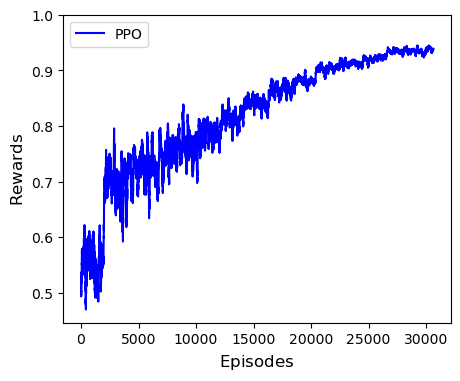

In [12]:
# Evaluate the agent
ppo_escaled_rewards = rescale_eposide_rewards(ppo_env.get_episode_rewards(), ppo_env.get_episode_lengths())
# moving average of results
ppo_average_results = rolling_average(ppo_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(ppo_average_results, label="PPO", color='blue')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Rewards$", fontsize=12)
plt.legend()
plt.ylim(ymax=1)
# save the plot
plt.savefig(os.path.join(images_path, f'ppo_reward_{numerical_id}.png'))

In [13]:
# Evaluate the trained agent
mean_ppo_reward, std_pp_reward = evaluate_policy(ppo_model, ppo_env)
print(f"mean_reward: {mean_ppo_reward:.4f} +/- {std_pp_reward:.4f}")

mean_reward: 0.9585 +/- 0.0012


In [14]:
model_path

'models/reward-one'

In [15]:
# save the model
ppo_model.save(os.path.join(model_path, f'ppo_reward_{numerical_id}'))

### B. SAC

In [16]:
# Choose your algorithm
SAC_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_one))
SAC_model = SAC("MlpPolicy", SAC_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
SAC_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.523    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 81       |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.607    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 77       |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.591    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 82       |
|    time_elapsed    | 0      

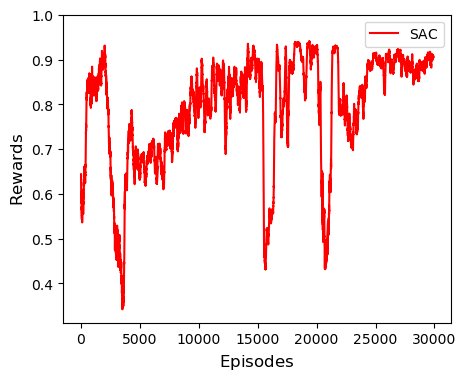

In [17]:
# Evaluate the agent
SAC_escaled_rewards = rescale_eposide_rewards(SAC_env.get_episode_rewards(), SAC_env.get_episode_lengths())
# moving average of results
SAC_average_results = rolling_average(SAC_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(SAC_average_results, label=r"$\rm SAC$", color='red')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Rewards$", fontsize=12)
plt.legend()
plt.ylim(ymax=1)
# save the figure
plt.savefig(os.path.join(images_path, f'sac_reward_{numerical_id}.png'))


In [18]:
# Evaluate the trained agent
mean_SAC_reward, std_SAC_reward = evaluate_policy(SAC_model, SAC_env)
print(f"mean_reward: {mean_SAC_reward:.4f} +/- {std_SAC_reward:.4f}")

mean_reward: 0.8416 +/- 0.1953


In [19]:
# save the model
SAC_model.save(os.path.join(model_path, f'sac_reward_{numerical_id}'))

In [20]:
ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_one)

### C. A2C

In [21]:
# Choose your algorithm
A2C_env = Monitor(ENV(rl_metrics=metrics, max_steps=max_steps, reward_function=reward_one))
A2C_model = A2C("MlpPolicy", A2C_env, verbose=1, seed=2048, learning_rate=0.001)
# Train the agent
A2C_model.learn(total_timesteps=number_of_episodes)

Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.866    |
| time/                 |          |
|    fps                | 84       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -6.92    |
|    explained_variance | -0.0159  |
|    learning_rate      | 0.001    |
|    n_updates          | 99       |
|    policy_loss        | 4.67     |
|    std                | 0.967    |
|    value_loss         | 0.501    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.903    |
| time/                 |          |
|    fps                | 84       |
|    iterations         | 200      |
|    time_elapsed      

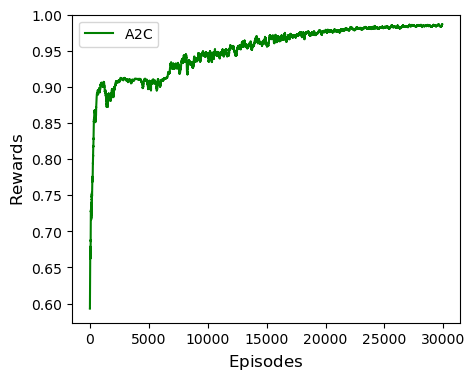

In [22]:
# Evaluate the agent
A2C_escaled_rewards = rescale_eposide_rewards(A2C_env.get_episode_rewards(), A2C_env.get_episode_lengths())
# moving average of results
A2C_average_results = rolling_average(A2C_escaled_rewards, window_size=window_size)
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(A2C_average_results, label=r"$\rm A2C$", color='green')
plt.xlabel(r"$\rm Episodes$", fontsize=12)
plt.ylabel(r"$\rm Rewards$", fontsize=12)
plt.ylim(ymax=1)
plt.legend()
# save the figure
plt.savefig(os.path.join(images_path, f'a2c_reward_{numerical_id}.png'))

In [23]:
# Evaluate the trained agent
mean_A2C_reward, std_A2C_reward = evaluate_policy(A2C_model, A2C_env)
print(f"mean_reward: {mean_A2C_reward:.4f} +/- {std_A2C_reward:.4f}")

mean_reward: 0.9881 +/- 0.0001


In [24]:
# save the model
A2C_model.save(os.path.join(model_path, f'a2c_reward_{numerical_id}'))

## Compare

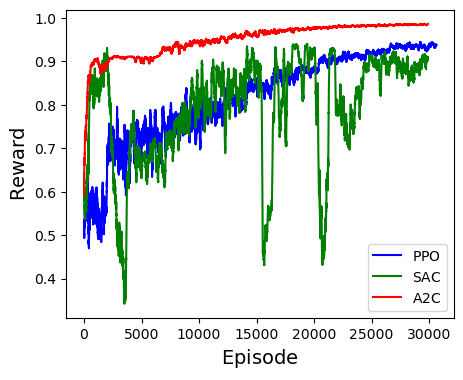

In [25]:
# plot the results
plt.figure(figsize=(5, 4))
plt.plot(ppo_average_results, label=r'$\rm PPO$', color='blue')
plt.plot(SAC_average_results, label=r'$\rm SAC$', color='green')
plt.plot(A2C_average_results, label=r'$\rm A2C$', color='red')
plt.xlabel(r'$\rm Episode$', fontsize=14)
plt.ylabel(r'$\rm Reward$', fontsize=14)
plt.legend()
plt.savefig(os.path.join(images_path, f'combined_reward_{numerical_id}.png'))

# Test controller

In [26]:
from OptiDial import test_controller

## A. PPO

In [27]:
ppo_action_recorder = test_controller(ppo_env, ppo_model, n_steps=10, id='ppo', ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [ 80.           2.         114.440216     0.93574506   0.37443066]
obs = [  0.9577963   1.5329521   1.4440957 103.64649  ]
reward = 0.9577963018628277
terminated =False
Step = 2
Action = [ 80.           2.         114.36929      0.9367191    0.37402785]
obs = [  0.9576978   1.5316204   1.4474659 103.74134  ]
reward = 0.9576978103023932
terminated =False
Step = 3
Action = [ 80.          2.        116.55154     0.9105258   0.391523 ]
obs = [  0.960503    1.5688978   1.35148   100.25345  ]
reward = 0.960502995790412
terminated =False
Step = 4
Action = [ 80.           2.         115.976685     0.91630596   0.3847716 ]
obs = [  0.9598264   1.5601585   1.3746312 101.43168  ]
reward = 0.9598264032742867
terminated =False
Step = 5
Action = [ 80.           2.         116.095505     0.9210346    0.39304978]
obs = [  0.95964473   1.5563774    1.3808473  100.41519   ]
reward = 0.9596447354198411
terminated =False
Step = 6
Action = [ 80.           2.         116.66257      0.90830

## B. SAC

In [28]:
SAC_action_recorder = test_controller(SAC_env, SAC_model, n_steps=10, id='sac', ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [ 71.          1.9820714 118.42853     1.5038555   0.4673164]
obs = [  0.91965777   1.1316056    2.7490923  106.8688    ]
reward = 0.919657775562202
terminated =False
Step = 2
Action = [52.          1.9747126  92.374535    0.56937003  0.11856654]
obs = [  0.9506833   1.6364096   1.6874839 166.71613  ]
reward = 0.9506832842235383
terminated =False
Step = 3
Action = [ 17.           1.3269986  119.83254      0.26058304   0.41886544]
obs = [ 0.9349014  1.1863145  2.2274961 54.905193 ]
reward = 0.9349014241702485
terminated =False
Step = 4
Action = [ 52.           1.9801556  114.24806      0.75888664   0.14746688]
obs = [  0.94468963   1.5824758    1.8925709  172.26826   ]
reward = 0.944689616074771
terminated =False
Step = 5
Action = [ 52.           1.9757969  114.52563      0.6944516    0.11990152]
obs = [  0.9507992   1.6580884   1.6835167 193.62741  ]
reward = 0.9507992225083532
terminated =False
Step = 6
Action = [ 67.           1.9818323  113.40187      1.1358926    

## C. A2C

In [29]:
A2C_action_recorder = test_controller(A2C_env, A2C_model, n_steps=10, id='a2c', ub=ub, lb=lb, write_path=model_path)

Step = 1
Action = [ 80.         2.       120.         0.493057   0.5     ]
obs = [ 0.98815954  2.0023944   0.40514824 67.593155  ]
reward = 0.9881595427994029
terminated =False
Step = 2
Action = [ 80.           2.         120.           0.49306715   0.5       ]
obs = [ 0.988159    2.0023835   0.40516713 67.59377   ]
reward = 0.9881589905098984
terminated =False
Step = 3
Action = [ 80.           2.         120.           0.49304783   0.5       ]
obs = [ 0.98816     2.0024042   0.40513113 67.59259   ]
reward = 0.9881600431027694
terminated =False
Step = 4
Action = [ 80.           2.         120.           0.49306685   0.5       ]
obs = [ 0.988159    2.002384    0.40516657 67.59376   ]
reward = 0.9881590067523688
terminated =False
Step = 5
Action = [ 80.           2.         120.           0.49306652   0.5       ]
obs = [ 0.988159    2.0023842   0.40516597 67.593735  ]
reward = 0.9881590246209985
terminated =False
Step = 6
Action = [ 80.           2.         120.           0.49347818   0.